In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import time
from PIL import Image
import torch.nn.functional as F
import torchvision.datasets as datasets
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns

In [2]:
# Load train data
train_label = pd.read_csv('../Datasets/dataset_AMLS_22-23/celeba/labels.csv', sep = "\t")  # read csv file
train_label.loc[train_label['gender'] == -1, 'gender'] = 0 
y_train = train_label['gender']
img_name1 = train_label['img_name']

x_train = []
for name in img_name1:
    img_path = '../Datasets/dataset_AMLS_22-23/celeba/img/' + name # get path based on image name
    img = Image.open(img_path)
    x_train.append(img)  # add pic to x_train

#split the validation dataset from test dataset
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=20)
    
#load test and vadilation data
data_test = pd.read_csv('../Datasets/dataset_AMLS_22-23_test/dataset_AMLS_22-23_test/celeba_test/labels.csv', sep = "\t")  # read csv file
data_test.loc[data_test['gender'] == -1, 'gender'] = 0 
y_test = data_test['gender']
img_name2 = data_test['img_name']

x_test=[]
for name in img_name2:
    img_path = '../Datasets/dataset_AMLS_22-23_test/dataset_AMLS_22-23_test/celeba_test/img/' + name  # get path based on image name
    img = Image.open(img_path)
    x_test.append(img)  # add pic to x_train

print("Dataset prepared")

Dataset prepared


In [3]:
# Transform
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.412,0.412,0.412], [0.245,0.245,0.245])
])
transform_test = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.412,0.412,0.412], [0.245,0.245,0.245])
])

# define the class that implement the transformation
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y.to_numpy())
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else: 
            return X
        
batch_size = 128
#transform and load the train, val, test data
train_set = ImgDataset(x_train, y_train, transform=transform_train)
val_set = ImgDataset(x_val, y_val, transform=transform_test)
test_set = ImgDataset(x_test, transform=transform_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
print("Dataset loaded")
print(len(train_set))
print(len(val_set))
print(len(test_set))

Dataset loaded
4000
1000
1000


In [4]:
#define the structure of CNN
class Classifier(nn.Module):
    def __init__(self, num_classes = 2): #binary classification
        super().__init__()
        self.num_classes = num_classes
        #convolutional layer
        self.conv2d = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128 * 8 * 8, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4, inplace=False),
            nn.Linear(in_features=256, out_features=num_classes)
        )
        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                
    #define input and output of the network           
    def forward(self, input):
        output = self.conv2d(input)
        output = self.fc(output)
        return output

print("Model completed")

Model completed


In [5]:
''' Training '''
print("Training")
print("...")
model = Classifier().cpu()

#define the loss function
loss = nn.BCEWithLogitsLoss() 
#loss =  nn.CrossEntropyLoss()

#define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 
num_epoch = 40
best_model = None
best_acc = 0

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    #train the model
    model.train() 
    for i, data in enumerate(train_loader):
        optimizer.zero_grad() 
        train_pred = model(data[0].cpu())
        target = data[1].cpu()
        target = torch.stack((1-target, target), dim=1)
        target = target.float()
        batch_loss = loss(train_pred, target) 
        batch_loss.backward() 
        optimizer.step()  
        train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        train_loss += batch_loss.item()
        
    #evaluate the model on val dataset
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            val_pred = model(data[0].cpu())
            target = data[1].cpu()
            target = torch.stack((1-target, target), dim=1)
            target = target.float()
            batch_loss = loss(val_pred, target)
            val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            val_loss += batch_loss.item()
            #if the current val accuracy is equal to or great than the best accuracy, update the best acc
            if val_acc >= best_acc:
                best_acc = val_acc
                #update the parameters of the best model
                best_model_params = model.state_dict()

        print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
              (epoch + 1, num_epoch, time.time() - epoch_start_time, \
               train_acc / train_set.__len__(), train_loss / train_set.__len__(), val_acc / val_set.__len__(),
               val_loss / val_set.__len__()))
print(best_acc)
print("Training completed")
#best_model.load_state_dict(best_model_params)
#save the best model's parameters in cnn_model.pt
torch.save(best_model_params, "cnn_model.pt")

Training
...
[001/040] 51.58 sec(s) Train Acc: 0.680000 Loss: 0.005108 | Val Acc: 0.820000 loss: 0.003644
[002/040] 51.93 sec(s) Train Acc: 0.792500 Loss: 0.003683 | Val Acc: 0.843000 loss: 0.003050
[003/040] 51.30 sec(s) Train Acc: 0.829750 Loss: 0.003237 | Val Acc: 0.861000 loss: 0.002668
[004/040] 49.73 sec(s) Train Acc: 0.854250 Loss: 0.002875 | Val Acc: 0.874000 loss: 0.002389
[005/040] 45.93 sec(s) Train Acc: 0.869750 Loss: 0.002529 | Val Acc: 0.889000 loss: 0.002166
[006/040] 44.76 sec(s) Train Acc: 0.883250 Loss: 0.002360 | Val Acc: 0.905000 loss: 0.001988
[007/040] 46.39 sec(s) Train Acc: 0.894500 Loss: 0.002123 | Val Acc: 0.915000 loss: 0.001819
[008/040] 44.93 sec(s) Train Acc: 0.906250 Loss: 0.001937 | Val Acc: 0.914000 loss: 0.001858
[009/040] 45.74 sec(s) Train Acc: 0.899500 Loss: 0.001936 | Val Acc: 0.920000 loss: 0.001593
[010/040] 45.40 sec(s) Train Acc: 0.913000 Loss: 0.001718 | Val Acc: 0.925000 loss: 0.001554
[011/040] 45.84 sec(s) Train Acc: 0.920000 Loss: 0.001673

Testing
...
Accuracy on test set: 0.96
Testing completed


Text(50.722222222222214, 0.5, 'true')

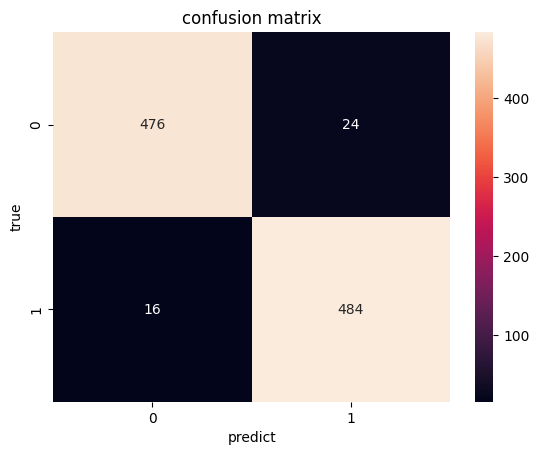

In [6]:
''' Testing '''
print("Testing")
print("...")
best_model = Classifier().cpu()
best_model.load_state_dict(torch.load("cnn_model.pt"))
best_model.eval()
prediction = []
#test the model on the test dataset
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = best_model(data.cpu())
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        for y in test_label:
            prediction.append(y)

print('Accuracy on test set: '+str(accuracy_score(y_test,prediction)))
print("Testing completed")
#confusion matrix
cm = confusion_matrix(y_test,prediction)
df_cm = pd.DataFrame(cm)
df_cm
ax = sns.heatmap(df_cm,annot=True,fmt='.20g')
ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 